# Predicting flood occurrence
Flood occurrences in downtown Norfolk are predicted based on rain, tide levels, water table levels, and wind speed/direction. 

In [1]:
repo = "http://cran.us.r-project.org"
library(caret)
library(ggfortify)
library(ggplot2)
library(dplyr)
library(rpart)
library(rpart.plot)
library(RSQLite)
library(DBI)
library(randomForest)
library(e1071)
library(class)

Warning message:
"package 'caret' was built under R version 3.3.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'ggfortify' was built under R version 3.3.3"Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rpart.plot' was built under R version 3.3.3"Warning message:
"package 'RSQLite' was built under R version 3.3.3"Warning message:
"package 'DBI' was built under R version 3.3.3"Warning message:
"package 'randomForest' was built under R version 3.3.3"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The followin

In [2]:
classify_knn = function(pca.data, obs_data, point, k){
  neighs = get_nn(pca.data, point, k)
  neigh_data = obs_data[neighs,]
  return(names(which.max(table(neigh_data$fld))))
}

In [3]:
get_nn = function(d, point, k){
  point = d[point, ]
  dists = sort(sqrt(rowSums((t(t(d) - point))^2)))
  close_points = names(dists)[2:k]
  return(close_points)
}

In [4]:
base_dir<- "C:/Users/Jeff/Documents/research/Sadler_3rdPaper/manuscript/"
data_dir<- paste(base_dir, "Data/", sep="")
fig_dir <- paste(base_dir, "Figures/general/", sep="")
db_filename <- "floodData.sqlite"

In [5]:
con = dbConnect(RSQLite::SQLite(), dbname=paste(data_dir, db_filename, sep=""))

In [6]:
df = dbReadTable(con, 'for_model_geog')

In [7]:
df = df[df$is_downtown == 1,]
df = df[!is.na(df$gw_daily_avg),]
df = subset(df, rain_daily_sum>0.1)

In [8]:
colnames(df)

[1] "level_0"                 "Date"                   
 [3] "count"                   "distance_to_OW"         
 [5] "distance_to_OW_EW"       "distance_to_OW_WW"      
 [7] "disttowat"               "elev"                   
 [9] "eventType"               "event_name"             
[11] "flood_pt"                "flooded"                
[13] "gw_daily_avg"            "index"                  
[15] "is_downtown"             "lat"                    
[17] "location"                "long"                   
[19] "num_flooded"             "num_imperv"             
[21] "rain_15_min_max"         "rain_15_min_max_time"   
[23] "rain_daily_sum"          "rain_hourly_max"        
[25] "rain_hourly_max_time"    "rain_prev_3_days"       
[27] "tide_daily_avg"          "tide_r15mx"             
[29] "tide_rhrmx"              "wind_dir_daily_avg"     
[31] "wind_vel_daily_avg"      "wind_vel_hourly_max_avg"
[33] "xcoord"                  "ycoord"

In [9]:
in_col_names = c('rain_daily_sum',
                 'rain_hourly_max',
                 'rain_15_min_max', 
                 'rain_prev_3_days', 
                 'gw_daily_avg', 
                 'tide_daily_avg', 
                 'wind_vel_daily_avg',
                 'tide_r15mx', 
                 'tide_rhrmx',
#                  'distance_to_OW',
                 'num_imperv',
                 'disttowat',
                 'elev'
                )
out_col_name = 'flooded'
model_data = df[, c(in_col_names, out_col_name)]
model_data[,out_col_name] = model_data[,out_col_name]>0
model_data[,out_col_name] = factor(model_data[,out_col_name])

In [10]:
head(model_data)

,rain_daily_sum,rain_hourly_max,rain_15_min_max,rain_prev_3_days,gw_daily_avg,tide_daily_avg,wind_vel_daily_avg,tide_r15mx,tide_rhrmx,num_imperv,disttowat,elev,flooded
3060410,0.810,0.28,0.25,0.810,2.411048,-0.03066667,8.30,-0.764,-0.013,143488,1989.63,3.17138,FALSE
3060414,0.355,0.10,0.03,0.440,2.934795,0.62091667,11.65,-0.256,0.010,143488,1989.63,3.17138,FALSE
3060418,1.345,0.91,0.43,1.345,3.449501,0.33045833,16.25,-0.010,-0.223,143488,1989.63,3.17138,FALSE
3060423,0.355,0.09,0.03,0.355,2.849785,0.29991667,21.35,-0.728,-0.728,143488,1989.63,3.17138,FALSE
3060425,0.145,0.09,0.03,0.530,3.072916,-0.23912500,3.00,-0.253,-0.253,143488,1989.63,3.17138,FALSE
3060427,0.235,0.15,0.08,0.450,3.613777,0.13179167,8.95,0.676,-0.039,143488,1989.63,3.17138,FALSE


In [11]:
print(summary(model_data$flooded))
sum(as.numeric(model_data$flooded == TRUE))/sum(as.numeric(model_data$flooded == FALSE))

 FALSE   TRUE 
167738    358 


[1] 0.002134281

### Partition data into training and testing sets

In [12]:
prt = createDataPartition(model_data[, out_col_name], p=0.7)
train_ind = prt$Resample1
test_ind = rownames(model_data[-train_ind,])
print(length(test_ind) + length(train_ind))
# length(rownames(model_data[model_data[train_ind, out_col_name]==TRUE]))
length(test_ind)

[1] 168096


[1] 50428

In [13]:
train_data = model_data[train_ind, ]
test_data = model_data[test_ind, ]

### Downsample negative records in training dataset

In [14]:
nfld_train = rownames(train_data[train_data[, out_col_name] == FALSE,])
fld_train = rownames(train_data[train_data[, out_col_name] == TRUE,])
nfld_test = rownames(test_data[test_data[, out_col_name] == FALSE,])
fld_test = rownames(test_data[test_data[, out_col_name] == TRUE,])
down_sample_percent = .002
nfld_train_dwnsmp = sample(nfld_train, down_sample_percent*length(nfld_train))
train_ind = c(fld_train, nfld_train_dwnsmp)

In [15]:
train_in_data = model_data[train_ind, in_col_names]
test_in_data = model_data[test_ind, in_col_names]

### Scale data

In [16]:
train_col_stds = apply(train_in_data, 2, sd)
train_col_means = colMeans(train_in_data)

In [17]:
train_normalized = t((t(train_in_data)-train_col_means)/train_col_stds)
test_normalized = t((t(test_in_data)-train_col_means)/train_col_stds)

### PCA transform

Standard deviations:
 [1] 1.9590987 1.6491421 1.1608904 1.0190096 0.9703729 0.8350585 0.7295342
 [8] 0.6383396 0.4963585 0.3378625 0.2513010 0.2321573

Rotation:
                           PC1          PC2          PC3         PC4
rain_daily_sum     -0.28295136  0.421011704 -0.006502795  0.30832339
rain_hourly_max     0.02011515  0.552856233 -0.097817268 -0.23645917
rain_15_min_max     0.10367986  0.520805317 -0.122591340 -0.28182432
rain_prev_3_days   -0.12498513  0.451035265  0.029916960  0.23690785
gw_daily_avg       -0.23178417 -0.006992518  0.061000313  0.71800039
tide_daily_avg     -0.45288950 -0.014415958  0.014943713 -0.05438771
wind_vel_daily_avg -0.43161405  0.007760337  0.122139084 -0.10870425
tide_r15mx         -0.45929927 -0.084760298  0.107788647 -0.26368651
tide_rhrmx         -0.43612560 -0.070646761  0.110882326 -0.28050763
num_imperv          0.07235571  0.009634052  0.686044057 -0.07978320
disttowat           0.17730819  0.156392442  0.604083828 -0.04725426
elev      

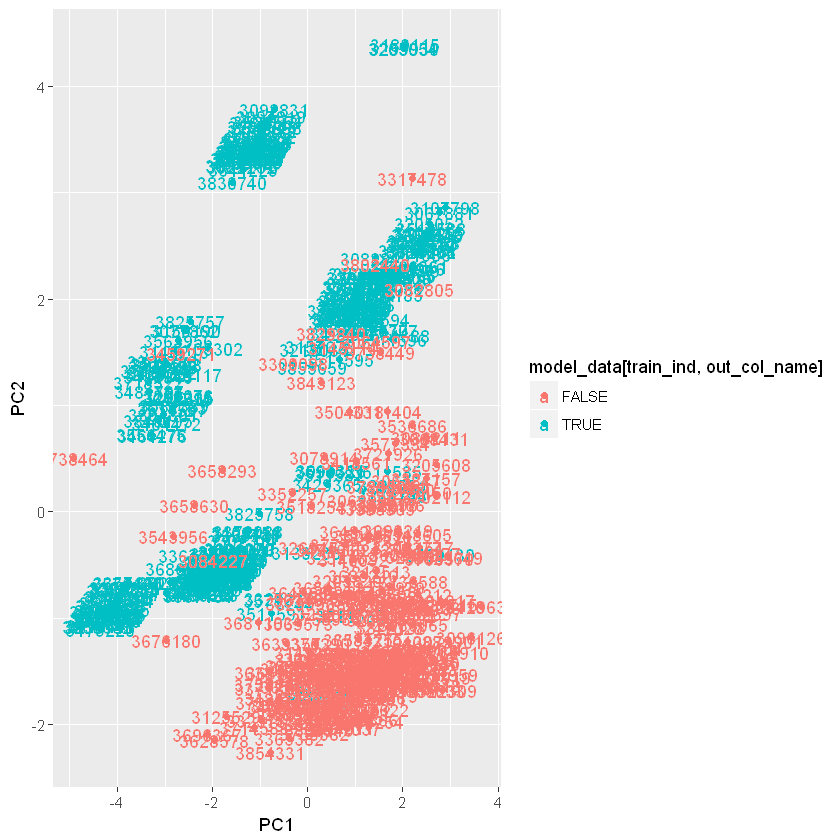

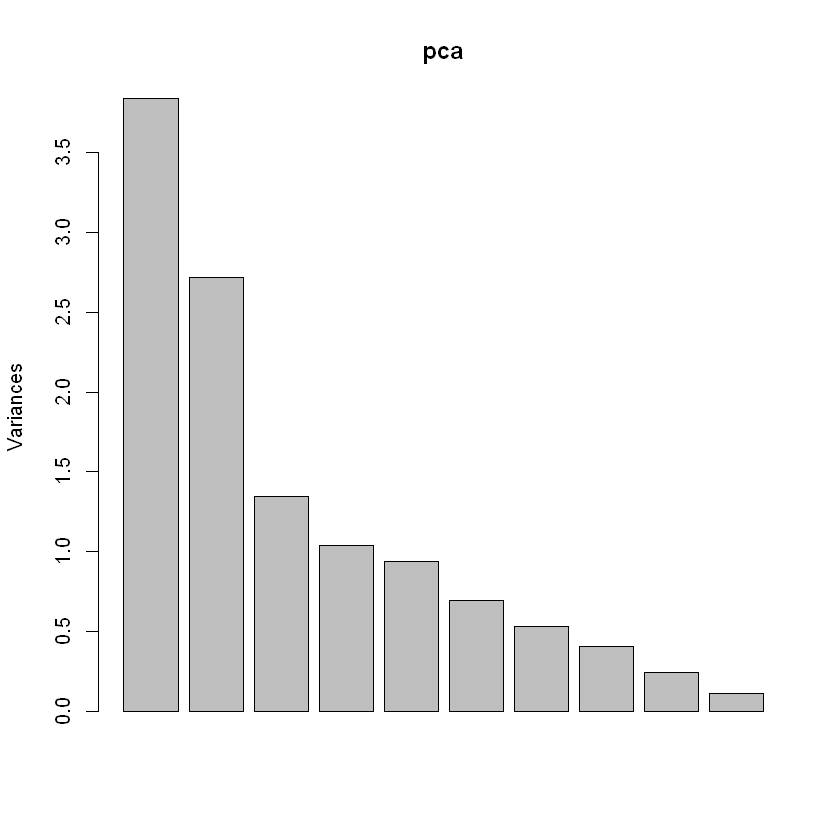

In [18]:
pca = prcomp(train_normalized)
pca$x = -pca$x
pca$rotation=-pca$rotation
p = ggplot(pca$x[,c(1,2)], aes(x=PC1, y=PC2, colour=model_data[train_ind, out_col_name], label=rownames(pca$x)))
p + geom_point() + geom_text()
print(pca)
plot(pca)

In [19]:
trn_preprocessed = predict(pca, train_normalized)
tst_preprocessed = predict(pca, test_normalized)
trn_in = trn_preprocessed
tst_in = tst_preprocessed

In [20]:
tst_out = model_data[test_ind, out_col_name]
trn_out = model_data[train_ind, out_col_name]
train_data = cbind(as.data.frame(trn_in), flooded = model_data[train_ind, out_col_name])
fmla = as.formula(paste(out_col_name, "~", paste(colnames(trn_in), collapse="+")))
fmla

flooded ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + 
    PC10 + PC11 + PC12

### KNN

In [21]:
kfit = knn(trn_in, tst_in, trn_out, k=5)
table(tst_out, kfit)

       kfit
tst_out FALSE  TRUE
  FALSE 46665  3656
  TRUE      8    99

### SVM

In [22]:
svm_fit = svm(fmla, data=train_data)
svm_pred = predict(svm_fit, tst_in)
table(tst_out, svm_pred)

       svm_pred
tst_out FALSE  TRUE
  FALSE 48444  1877
  TRUE      7   100

### Decision Trees

In [23]:
dt_fmla = as.formula(paste(out_col_name, "~", paste(in_col_names, collapse="+")))
dt_train_data = model_data[train_ind, ]
dt_test_data = model_data[test_ind, in_col_names]

In [24]:
fit = rpart(dt_fmla, method='class', data=dt_train_data, minsplit=2)
printcp(fit)


Classification tree:
rpart(formula = dt_fmla, data = dt_train_data, method = "class", 
    minsplit = 2)

Variables actually used in tree construction:
[1] rain_daily_sum   rain_prev_3_days tide_rhrmx      

Root node error: 234/485 = 0.48247

n= 485 

        CP nsplit rel error  xerror     xstd
1 0.854701      0  1.000000 1.00000 0.047028
2 0.038462      1  0.145299 0.15385 0.024671
3 0.012821      2  0.106838 0.11538 0.021579
4 0.010000      3  0.094017 0.11538 0.021579


png 
  2

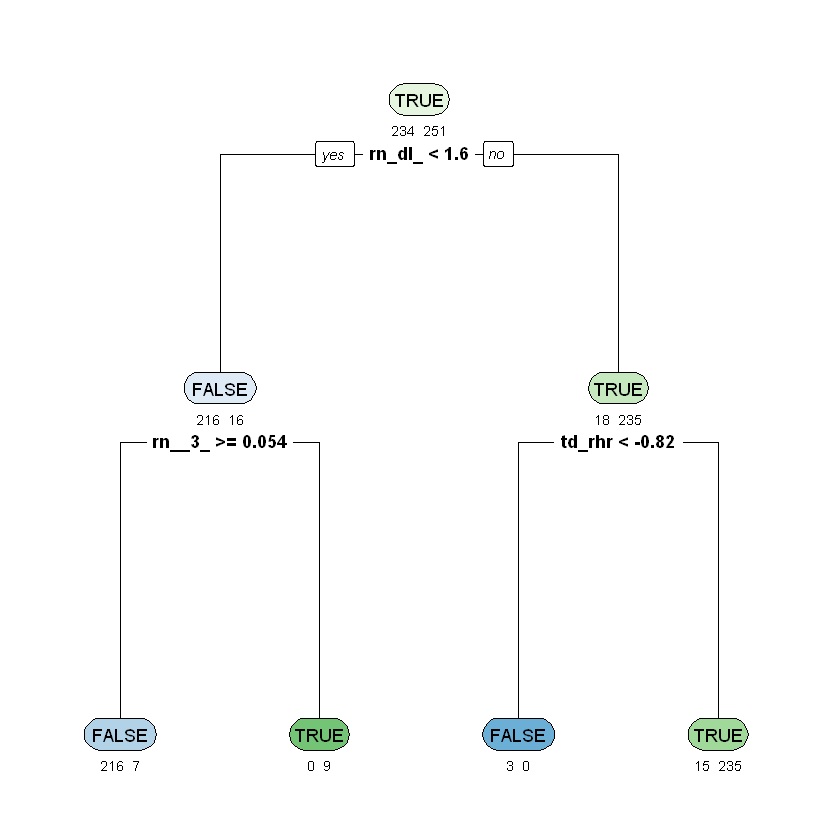

In [25]:
tiff(paste(fig_dir, "Plot2.tif"), width=9, height=6, units='in', res = 300)
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)
dev.off()
rpart.plot(fit, under=TRUE, cex=0.9, extra=1, varlen = 6)

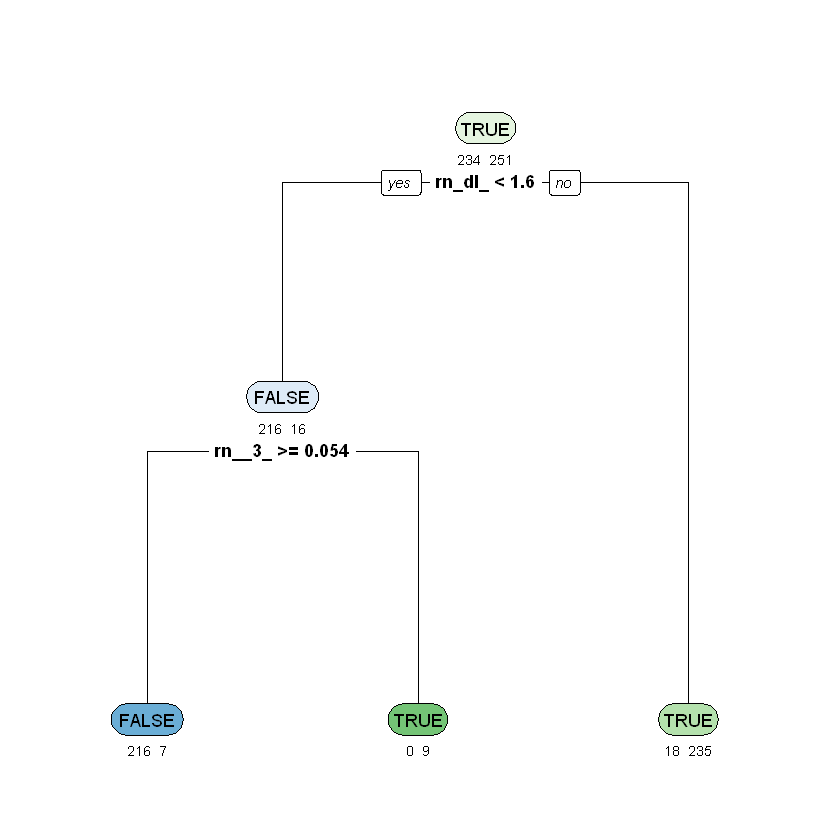

In [26]:
pfit<- prune(fit, cp=fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
rpart.plot(pfit, under=TRUE, cex=0.9, extra=1, varlen = 6)

#### Decision Tree training results

In [27]:
pred = predict(pfit, dt_train_data[, in_col_names], type = 'class')
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   216   18
  TRUE      7  244

#### Decision Tree testing results

In [28]:
pred = predict(pfit, dt_test_data, type = 'class')
table(tst_out, pred)

       pred
tst_out FALSE  TRUE
  FALSE 46406  3915
  TRUE      3   104

### Random Forests

In [29]:
forest = randomForest(dt_fmla, data = dt_train_data, importance = TRUE, type="classification", nodesize=2)

pred = predict(forest, dt_train_data[, in_col_names])
table(trn_out, pred)

       pred
trn_out FALSE TRUE
  FALSE   233    1
  TRUE      0  251

       pred
tst_out FALSE  TRUE
  FALSE 48603  1718
  TRUE      2   105

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"duplicated levels in factors are deprecated"Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
"d

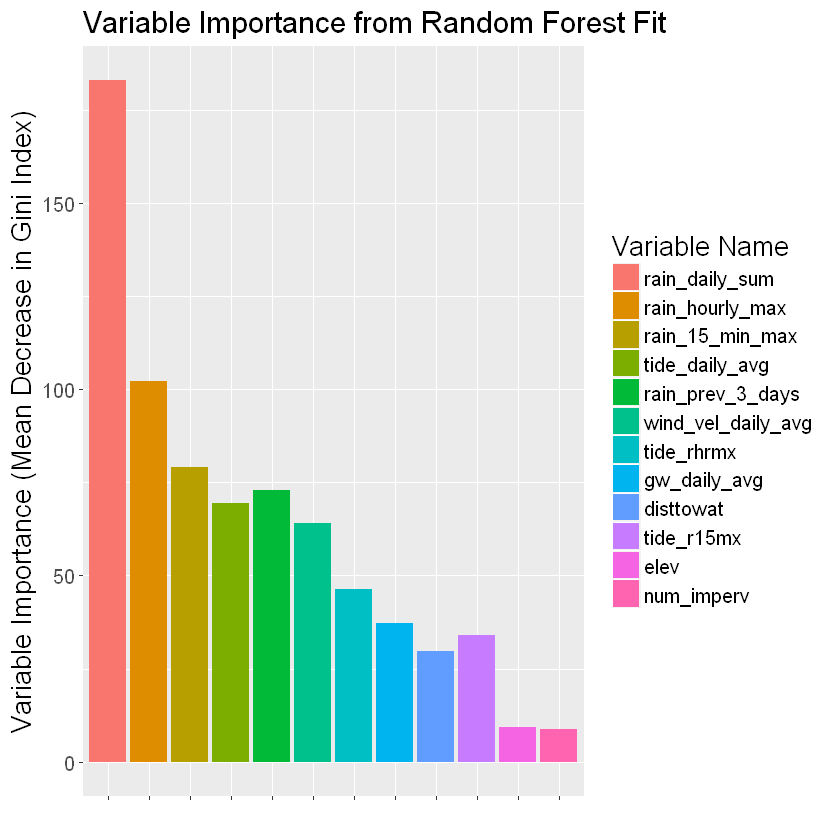

In [30]:
pred = predict(forest, dt_test_data)
table(tst_out, pred)
var_importance <- data.frame(variable=setdiff(colnames(dt_train_data), out_col_name),
                             importance=as.vector(importance(forest)))
var_importance <- arrange(var_importance, desc(importance))
var_importance$variable <- factor(var_importance$variable, levels=var_importance$variable)

p <- ggplot(var_importance, aes(x=variable, weight=importance, fill=variable))
p <- p + geom_bar() + ggtitle("Variable Importance from Random Forest Fit")
p <- p + xlab("") + ylab("Variable Importance (Mean Decrease in Gini Index)")
p <- p + scale_fill_discrete(name="Variable Name")
p + theme(axis.text.x=element_blank(),
          axis.text.y=element_text(size=12),
          axis.title=element_text(size=16),
          plot.title=element_text(size=18),
          legend.title=element_text(size=16),
          legend.text=element_text(size=12))

### Logistic Regression

In [31]:
lo_fit = glm(fmla, family=binomial(link='logit'), data=train_data)
print(lo_fit)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:  glm(formula = fmla, family = binomial(link = "logit"), data = train_data)

Coefficients:
(Intercept)          PC1          PC2          PC3          PC4          PC5  
    1.74697     -2.07987      1.95264     -0.20020     -0.03452      0.32161  
        PC6          PC7          PC8          PC9         PC10         PC11  
    2.49676     -0.04905     -6.51634      0.07319     -8.64797      5.09632  
       PC12  
    3.06486  

Degrees of Freedom: 484 Total (i.e. Null);  472 Residual
Null Deviance:	    671.8 
Residual Deviance: 142.4 	AIC: 168.4


In [32]:
pred = predict(lo_fit, as.data.frame(tst_in), type="response")
table(tst_out, round(pred)>0)

       
tst_out FALSE  TRUE
  FALSE 47350  2971
  TRUE      9    98